<a href="https://colab.research.google.com/github/EldarEyvazov/PolypSegmentation/blob/main/resunet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
# File processing
from glob import glob
import json
from PIL import Image
from tqdm import tqdm

# Splitting data into train and test sets
from sklearn.model_selection import train_test_split

# Data and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Concatenate, UpSampling2D, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [ ]:
pip install tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np

def read_and_resize_images(img_folder_path, desired_size=(256, 256)):
    images = []
    img_paths = []
    for image_name in sorted(os.listdir(img_folder_path)):
        image_path = os.path.join(img_folder_path, image_name)
        img_paths.append(image_path)

    for img_path in img_paths:
        img = cv2.imread(img_path)
        img = cv2.resize(img, desired_size)
        images.append(img)

    return np.array(images), img_paths

images_folder_path = "/content/drive/MyDrive/Vision Cognitive systems/Kvasir-SEG no augmentation/images"
images, img_p = read_and_resize_images(images_folder_path)


In [ ]:
import os
import cv2
import numpy as np

def read_and_resize_masks(mask_folder_path, desired_size=(256, 256)):
    masks = []
    mask_paths = []
    for mask_name in sorted(os.listdir(mask_folder_path)):
        mask_path = os.path.join(mask_folder_path, mask_name)
        mask_paths.append(mask_path)

    for mask_path in mask_paths:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, desired_size)
        masks.append(mask)

    return np.array(masks), mask_paths

masks_folder_path = "/content/drive/MyDrive/Vision Cognitive systems/Kvasir-SEG no augmentation/masks"
masks, mask_p = read_and_resize_masks(masks_folder_path)


In [ ]:
def split_data(images, masks, split=0.2):
    total_size = len(images)
    test_size  = int(split * total_size)
    valid_size = int(split * total_size)

    X_train, X_valid = train_test_split(images, test_size=valid_size, random_state=42)
    y_train, y_valid = train_test_split(masks, test_size=valid_size, random_state=42)

    X_train, X_test = train_test_split(X_train, test_size=test_size, random_state=42)
    y_train, y_test = train_test_split(y_train, test_size=test_size, random_state=42)
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

In [ ]:
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = split_data(images, masks)

print(f"train set size: {len(X_train)}\nvalid set size: {len(X_valid)}\ntest set size:  {len(X_test)}")

train set size: 600
valid set size: 200
test set size:  200


In [ ]:
# Find the maximum and minimum pixel values in each channel of the images array
max_pixel_values = np.amax(images, axis=(0, 1, 2))  # Max value for each channel
min_pixel_values = np.amin(images, axis=(0, 1, 2))  # Min value for each channel

print("Maximum pixel values (R, G, B):", max_pixel_values)
print("Minimum pixel values (R, G, B):", min_pixel_values)


Maximum pixel values (R, G, B): [255 255 255]
Minimum pixel values (R, G, B): [0 0 0]


In [ ]:
# Rescale the pixel values of images to the range [0, 1] for each channel
images = images / 255.0

# Find the maximum and minimum pixel values in each channel of the rescaled images array
max_rescaled_values = np.amax(images, axis=(0, 1, 2))  # Max value for each channel
min_rescaled_values = np.amin(images, axis=(0, 1, 2))  # Min value for each channel

print("Maximum rescaled pixel values (R, G, B):", max_rescaled_values)
print("Minimum rescaled pixel values (R, G, B):", min_rescaled_values)

Maximum rescaled pixel values (R, G, B): [1. 1. 1.]
Minimum rescaled pixel values (R, G, B): [0. 0. 0.]


In [ ]:
# Find the maximum and minimum pixel values in the masks array
max_pixel_value = np.amax(masks)
min_pixel_value = np.amin(masks)

print("Maximum pixel value for the masks:", max_pixel_value)
print("Minimum pixel value for the masks:", min_pixel_value)



Maximum pixel value for the masks: 255
Minimum pixel value for the masks: 0


In [ ]:

# Rescale the pixel values of masks to the range [0, 1]
masks = masks / max_pixel_value

# Find the maximum and minimum pixel values in the rescaled masks array
max_rescaled_value = np.amax(masks)
min_rescaled_value = np.amin(masks)

print("Maximum rescaled pixel value for the masks:", max_rescaled_value)
print("Minimum rescaled pixel value for the masks:", min_rescaled_value)

Maximum rescaled pixel value for the masks: 1.0
Minimum rescaled pixel value for the masks: 0.0


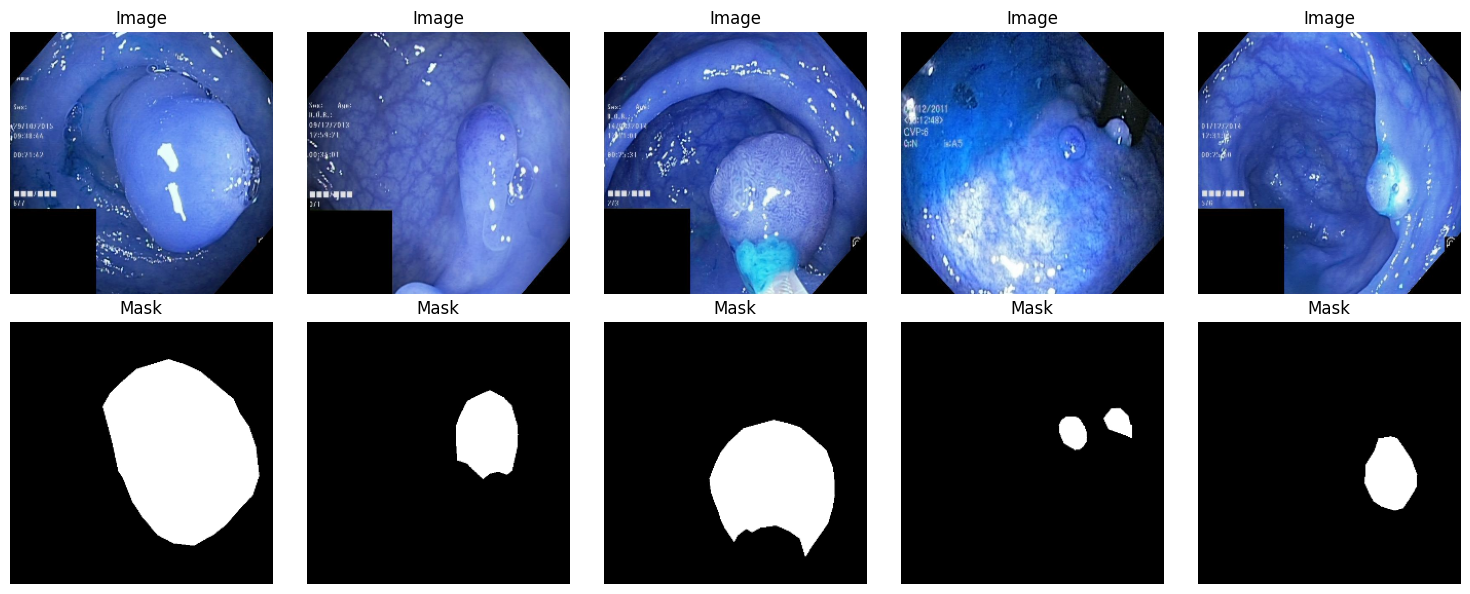

In [ ]:
import matplotlib.pyplot as plt
import random


# Set up the figure for plotting
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Randomly select 5 indices
random_indices = random.sample(range(len(images)), 5)

# Plot the images and masks
for i, idx in enumerate(random_indices):
    # Plot the image
    axes[0, i].imshow(images[idx])
    axes[0, i].set_title("Image")
    axes[0, i].axis("off")

    # Plot the mask
    axes[1, i].imshow(masks[idx], cmap='gray')
    axes[1, i].set_title("Mask")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
from tqdm import tqdm
import albumentations as A
import numpy as np

# Define Albumentations transformations
transformations = A.Compose(
    [
        A.OneOrOther(
            A.Compose([
                A.RandomRotate90(),
                A.HorizontalFlip(p=0.5)
            ]),
            A.Rotate(p=0.5)
        ),
        A.HorizontalFlip(p=1),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.2)
    ]
)

# Create lists for storing the augmented images and masks
augmented_images = []
augmented_masks = []

# Number of times to apply augmentation for each image
num_augmentations = 4

# Apply transformations
for image, mask in tqdm(zip(X_train, y_train), total=X_train.shape[0]):
    for _ in range(num_augmentations):
        # Apply Albumentations transformations
        augmented = transformations(image=image, mask=mask)
        augmented_images.append(augmented['image'])
        augmented_masks.append(augmented['mask'])

# Convert the lists to numpy arrays
X_train = np.array(augmented_images)
y_train = np.array(augmented_masks)


100%|██████████| 600/600 [00:04<00:00, 137.56it/s]


In [ ]:
X_train.shape

(2400, 256, 256, 3)

# ResUnet



In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

# Define custom metrics
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection+smooth ) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    total = K.sum(y_true_f) + K.sum(y_pred_f)
    union = total - intersection
    return (intersection+smooth ) / (union + smooth)




In [ ]:

# Ensure masks are binary
y_train = (y_train > 0).astype('float32')
y_valid = (y_valid > 0).astype('float32')
y_test = (y_test > 0).astype('float32')


# batch size 12

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, BatchNormalization, Activation, Add, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def residual_block(x, filters, kernel_size=3):
    shortcut = Conv2D(filters, kernel_size=1, padding='same', kernel_regularizer=l2(1e-4))(x)
    shortcut = BatchNormalization()(shortcut)
    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def encoder_block(x, filters):
    x = residual_block(x, filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(x, skip_features, filters):
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters, kernel_size=1, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = concatenate([x, skip_features])
    x = residual_block(x, filters)
    return x

def ResUNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    # Bridge
    b1 = residual_block(p4, 512)

    # Decoder
    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(num_classes, 1, padding='same', activation='sigmoid')(d4)

    model = Model(inputs, outputs, name='ResUNet')
    return model

# Define the input parameters
input_shape = (256, 256, 3)
num_classes = 1

# Create the model
model = ResUNet(input_shape, num_classes)

# Print the model summary
model.summary()


Model: "ResUNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_225 (Conv2D)         (None, 256, 256, 32)         896       ['input_8[0][0]']             
                                                                                                  
 batch_normalization_218 (B  (None, 256, 256, 32)         128       ['conv2d_225[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_154 (Activation  (None, 256, 256, 32)         0         ['batch_normalization_21

In [ ]:
import tensorflow as tf

# Define the dice loss function
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, 'float32')  # Ensure y_true is float32
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)



import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint





def train_model(model, train_data, val_data, batch_size, epochs, save_path):

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Define learning rate scheduler callback
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-9, verbose=1)

    # Define model checkpoint callback to save the best model
    model_checkpoint = ModelCheckpoint(filepath=save_path, monitor='val_loss', save_best_only=True, save_weights_only=False)

    # Compile the model (assuming binary segmentation)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                  loss=dice_loss,
                  metrics=['accuracy',iou_coef, dice_coef])

    # Train the model
    history = model.fit(train_data,
                        validation_data=val_data,
                        epochs=epochs,
                        callbacks=[early_stopping, lr_scheduler, model_checkpoint])

    return history

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))


# Batch the datasets
train_dataset = train_dataset.batch(12).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(12).prefetch(tf.data.experimental.AUTOTUNE)

# Define the input parameters
input_shape = (256, 256, 3)
num_classes = 1

# Create the model
model = ResUNet(input_shape, num_classes)

# Train the model
history = train_model(model, train_data=train_dataset, val_data=val_dataset, batch_size=12, epochs=50, save_path='best_model')


Epoch 1/50
200/200 [==============================] - 100s 412ms/step - loss: 0.9427 - accuracy: 0.7300 - iou_coef: 0.2908 - dice_coef: 0.4401 - val_loss: 0.8709 - val_accuracy: 0.6615 - val_iou_coef: 0.2989 - val_dice_coef: 0.4551 - lr: 3.0000e-04
Epoch 2/50
200/200 [==============================] - 81s 404ms/step - loss: 0.7722 - accuracy: 0.8162 - iou_coef: 0.3579 - dice_coef: 0.5185 - val_loss: 0.7064 - val_accuracy: 0.8121 - val_iou_coef: 0.3912 - val_dice_coef: 0.5554 - lr: 3.0000e-04
Epoch 3/50
200/200 [==============================] - 81s 407ms/step - loss: 0.6833 - accuracy: 0.8439 - iou_coef: 0.3963 - dice_coef: 0.5587 - val_loss: 0.6609 - val_accuracy: 0.8028 - val_iou_coef: 0.3981 - val_dice_coef: 0.5634 - lr: 3.0000e-04
Epoch 4/50
200/200 [==============================] - 69s 342ms/step - loss: 0.6182 - accuracy: 0.8612 - iou_coef: 0.4309 - dice_coef: 0.5925 - val_loss: 0.7559 - val_accuracy: 0.8743 - val_iou_coef: 0.2868 - val_dice_coef: 0.4403 - lr: 3.0000e-04
Epoch 5

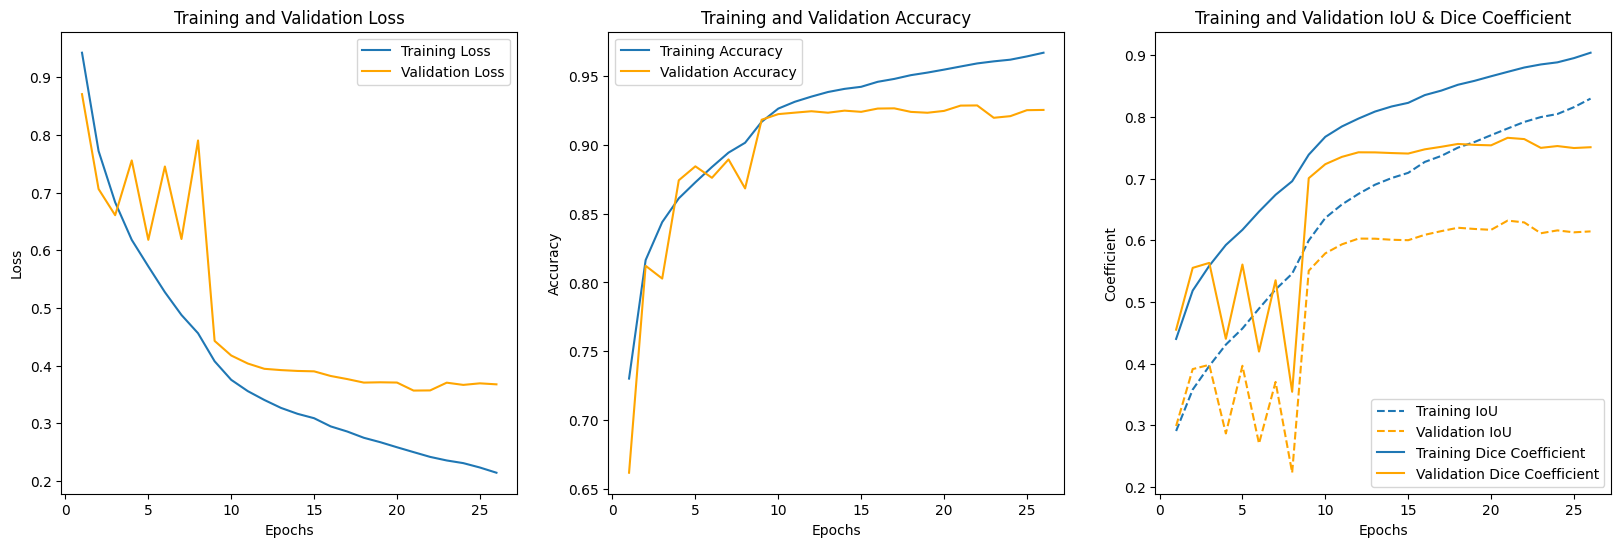

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics from the history object
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
iou = history_dict['iou_coef']
val_iou = history_dict['val_iou_coef']
dice = history_dict['dice_coef']
val_dice = history_dict['val_dice_coef']

epochs = range(1, len(loss) + 1)

# Plot training and validation metrics
plt.figure(figsize=(20, 6))

# Subplot 1: Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, loss, label='Training Loss', color='#1f77b4')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)

# Subplot 2: Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, accuracy, label='Training Accuracy', color='#1f77b4')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)

# Subplot 3: IoU and Dice Coefficient
plt.subplot(1, 3, 3)
plt.plot(epochs, iou, label='Training IoU', color='#1f77b4', linestyle='--')
plt.plot(epochs, val_iou, label='Validation IoU', color='orange',linestyle='--')
plt.plot(epochs, dice, label='Training Dice Coefficient', color='#1f77b4')
plt.plot(epochs, val_dice, label='Validation Dice Coefficient', color='orange')
plt.title('Training and Validation IoU & Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Coefficient')
plt.legend()
plt.grid(False)


plt.show()


25/25 [==============================] - 2s 71ms/step - loss: 0.3358 - accuracy: 0.9382 - iou_coef: 0.6536 - dice_coef: 0.7868
Test Loss: 0.33575204014778137
Test Accuracy: 0.9382070302963257
IoU: 0.653580904006958
Dice: 0.7868210077285767
25/25 [==============================] - 2s 66ms/step


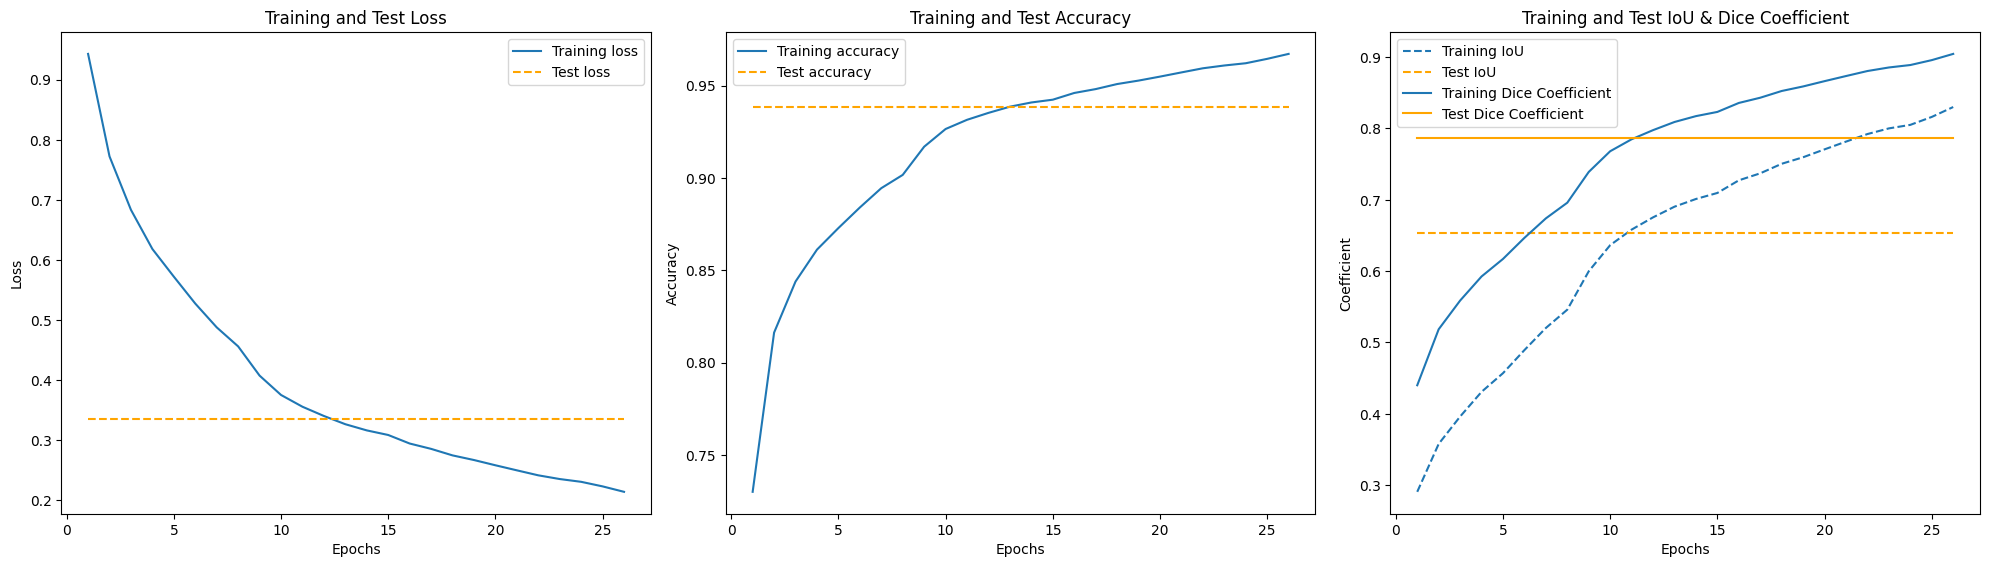

In [ ]:
import matplotlib.pyplot as plt

# Evaluate the model on the test set
loss, accuracy, iou, dice = model.evaluate(X_test, y_test, batch_size=12)
print(f'Test Loss: {loss}\nTest Accuracy: {accuracy}\nIoU: {iou}\nDice: {dice}')

# Generate predictions on the test set
predictions = model.predict(X_test, batch_size=8)

# Extract metrics from the history object
history_dict = history.history
train_loss = history_dict['loss']
train_accuracy = history_dict['accuracy']
train_iou = history_dict['iou_coef']
train_dice = history_dict['dice_coef']

epochs = range(1, len(train_loss) + 1)

# Create lists for test metrics to match the number of epochs
test_loss_list = [loss] * len(epochs)
test_accuracy_list = [accuracy] * len(epochs)
test_iou_list = [iou] * len(epochs)
test_dice_list = [dice] * len(epochs)

# Plot training and test metrics
plt.figure(figsize=(20, 6))

# Subplot 1: Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss, label='Training loss', color="#1f77b4")
plt.plot(epochs, test_loss_list, label='Test loss', color='orange', linestyle='--')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)

# Subplot 2: Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracy, label='Training accuracy', color='#1f77b4')
plt.plot(epochs, test_accuracy_list, label='Test accuracy', color='orange', linestyle='--')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)

# Subplot 3: IoU and Dice Coefficient
plt.subplot(1, 3, 3)
plt.plot(epochs, train_iou, label='Training IoU', color='#1f77b4', linestyle='--')
plt.plot(epochs, test_iou_list, label='Test IoU', color='orange', linestyle='--')
plt.plot(epochs, train_dice, label='Training Dice Coefficient', color='#1f77b4')
plt.plot(epochs, test_dice_list, label='Test Dice Coefficient', color='orange')
plt.title('Training and Test IoU & Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Coefficient')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top margin
plt.show()
